In [1]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

In [2]:
import sys, os
if 'google.colab' in sys.modules:
    %cd
    % rm -rf MPyDATA
    ! git clone --recurse-submodules -j8 https://github.com/Michaeldz36/MPyDATA.git
    %cd MPyDATA
    ! git checkout develop
    ! pip install -U $(cat requirements.txt | cut -d '=' -f 1)
else:
    sys.path.append(os.path.join(os.getcwd(), '../..'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from MPyDATA_examples.Olesik_et_al_2020.setup import Setup
from MPyDATA_examples.Olesik_et_al_2020.coordinates import x_id, x_p2, x_p3, x_log_of_pn
from MPyDATA.options import Options
from MPyDATA_examples.Olesik_et_al_2020.simulation import Simulation
from MPyDATA_examples.utils.show_plot import show_plot
from joblib import Parallel, parallel_backend, delayed
from MPyDATA_examples.Olesik_et_al_2020.physics.equilibrium_drop_growth import PdfEvolver
from MPyDATA.arakawa_c.discretisation import discretised_analytical_solution
from MPyDATA_examples.utils.error_norms import L2, Smolarkiewicz_Grabowski_1990_eq21

from MPyDATA_examples.Olesik_et_al_2020.convergence_plotter  import plot, polar_plot

In [4]:
GCs = np.linspace(.05,.95, 5)
nrs = np.linspace(16, 1024, 5, dtype = int)

In [5]:
grid_layout = x_p2()
psi_coord = x_p2()
setup = Setup()

In [6]:
def analysis(setup, GC, opt):
    options = Options(**opt)
    simulation = Simulation(setup, grid_layout,  psi_coord, options, GC)
    simulation.step(simulation.out_steps[-1])
    t = simulation.out_steps[-1] * simulation.dt
    rh = simulation.rh
    pdf_t = PdfEvolver(setup.pdf, setup.drdt, t)
    analytical = discretised_analytical_solution(
                simulation.rh.magnitude,
                lambda r: pdf_t(r * rh.units).magnitude
            ) * pdf_t(rh[0]).units
    numerical = simulation.n
    
    loc_of_maximum_numeric = simulation.r[np.argmax(numerical)]
    loc_of_maximum_analytic = simulation.r[np.argmax(analytical)]
    maximum_numeric = np.max(numerical)
    maximum_analytic = np.max(analytical)
    measure_location = (loc_of_maximum_numeric / loc_of_maximum_analytic).magnitude
    measure_height = (maximum_numeric / maximum_analytic).magnitude
    
    error = np.log2(Smolarkiewicz_Grabowski_1990_eq21(numerical.magnitude, analytical.magnitude, t.magnitude))
    return setup.nr, GC, error, measure_location, measure_height

In [7]:
opt_set = (
    {'n_iters': 1},
     {'n_iters': 2},
     {'n_iters': 2,'infinite_gauge':True},
     {'n_iters': 2, 'infinite_gauge': True, 'flux_corrected_transport': True},
     {'n_iters': 2, 'third_order_terms':True},
     {'n_iters': 3},
     {'n_iters': 3, 'third_order_terms': True, 'infinite_gauge': True, 'flux_corrected_transport': True}
)


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  15 out of  25 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  18 out of  25 | elapsed:  2.2min remaining:   51.0s
[Parallel(n_jobs=-2)]: Done  21 out of  25 | elapsed:  2.4min remaining:   27.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  3.0min finished
No handles with labels found to put in legend.


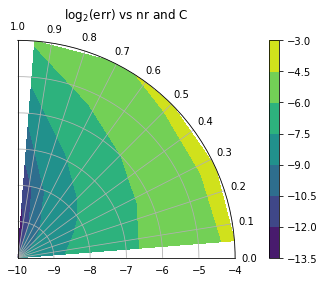

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  15 out of  25 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  18 out of  25 | elapsed:  2.2min remaining:   51.7s
[Parallel(n_jobs=-2)]: Done  21 out of  25 | elapsed:  2.8min remaining:   32.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  3.1min finished
No handles with labels found to put in legend.


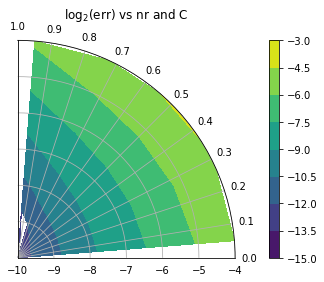

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  15 out of  25 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-2)]: Done  18 out of  25 | elapsed:  2.3min remaining:   53.2s
[Parallel(n_jobs=-2)]: Done  21 out of  25 | elapsed:  2.8min remaining:   32.1s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  3.1min finished
No handles with labels found to put in legend.


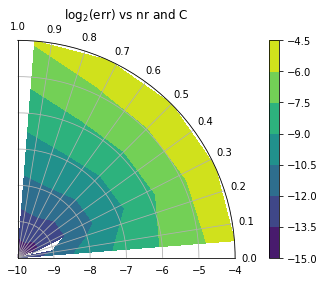

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.2min


In [ ]:
for opt in opt_set:
    with parallel_backend('threading', n_jobs=-2):
        results0 = Parallel(verbose=10)(
            delayed(analysis)(Setup(nr = nr, mixing_ratios_g_kg = [1.1,]), GC, opt)
            for nr in nrs
            for GC in GCs
        )
    results = [list(i) for i in zip(*results0)]
    plot_setup = np.array(results[0:2])
    measures = {'log$_2$(err)':results[2]} #, 'location':results[3], 'height':results[3]}  # TODO: add secondary measures when first one makes sense
    for measure in measures.keys():
        plot(plot_setup[0], plot_setup[1], measures[measure], name = measure)
        show_plot(filename = f'convergence_{measure}.pdf')
        polar_plot(nrs, GCs, measures[measure], name = measure)